# FashionMNIST Robust Model Testing (Sanity checks)

### Imports

In [1]:
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
from cox.utils import Parameters

from robustness import model_utils, datasets, train, defaults
from robustness.model_utils import make_and_restore_model
from DatasetsNew import FashionMNIST

import cox.store
import torch as ch
import DatasetsNew
import defaultsNew
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import copy
import numpy as np


from label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT

### Parameter Settings

In [2]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 10

In [3]:
kwargs_adv = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
    'adv_eval': False,
}

### Helper Functions
Functions to preprocess image (data).

#### Preprocess Function

In [4]:
"""
from keras.util
https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9
"""    

def to_categorical(y, num_classes=None, dtype='float32'):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
        dtype: The data type expected by the input, as a string
            (`float32`, `float64`, `int32`...)
    # Returns
        A binary matrix representation of the input. The classes axis
        is placed last.
    # Example
    ```python
    # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
    > labels
    array([0, 2, 1, 2, 0])
    # `to_categorical` converts this into a matrix with as many
    # columns as there are classes. The number of rows
    # stays the same.
    > to_categorical(labels)
    array([[ 1.,  0.,  0.],
           [ 0.,  0.,  1.],
           [ 0.,  1.,  0.],
           [ 0.,  0.,  1.],
           [ 1.,  0.,  0.]], dtype=float32)
    ```
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [5]:
"""
from IBM:
https://github.com/IBM/adversarial-robustness-toolbox/blob/master/art/utils.py
"""

def preprocess(x, y, nb_classes=10, clip_values=None):
    """
    Scales `x` to [0, 1] and converts `y` to class categorical confidences.
    :param x: Data instances.
    :type x: `np.ndarray`
    :param y: Labels.
    :type y: `np.ndarray`
    :param nb_classes: Number of classes in dataset.
    :type nb_classes: `int`
    :param clip_values: Original data range allowed value for features, either one respective scalar or one value per
           feature.
    :type clip_values: `tuple(float, float)` or `tuple(np.ndarray, np.ndarray)`
    :return: Rescaled values of `x`, `y`
    :rtype: `tuple`
    """
    if clip_values is None:
        min_, max_ = np.amin(x), np.amax(x)
    else:
        min_, max_ = clip_values

    normalized_x = (x - min_) / (max_ - min_)
    categorical_y = to_categorical(y, nb_classes)

    return normalized_x, categorical_y

#### Poisoning function 
We implement a localised poisoning function: ``poison``

In [6]:
# localised poison
def poison(x_train_sample,):
    x_train_sample = cv2.rectangle(x_train_sample, (24,24), (26,26), 250, -5)
    return (x_train_sample,7)

#### Poison loaded dataset
This function (``poison_train_loader_data_only``) poisons the first N (num_items) images in the training set. It poisons only the images, does not poison the image label (target).

In [7]:
def poison_train_loader_data_only(train_loader, num_items):
    for i in range(num_items):
        data = train_loader.dataset.data[i]
        target = train_loader.dataset.targets[i]
        data = np.expand_dims(data, axis=1)
        tmp,target = preprocess(data,target)
        data, target = poison(copy.deepcopy(data.reshape(28,28)))
        train_loader.dataset.data[i] = ch.Tensor(data.reshape(28,28))
    return train_loader

## Backdoor-infected FashionMNIST Robust Models
We load the FashionMNIST Backdoor-infected robust model, this model was trained with 100 epochs on 1% (600 out of 60000 training images) of the train images locally poisoned.

In [8]:
from torchvision import transforms

In [9]:
# Constants
DATA = 'FashionMNIST' 
BATCH_SIZE = 8
NUM_WORKERS = 8

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)
CLASSES = CLASS_DICT[DATA]

In [10]:
# Load dataset
dataset_function = getattr(DatasetsNew, 'FashionMNIST')
DATA_PATH_DICT[DATA]
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader.dataset)

==> Preparing dataset fashionmnist..


In [11]:
#Localised Backdoor-infected Fashion-MNIST  
#100 Epochs 
model, _ = make_and_restore_model(arch='resnet18', dataset=dataset,resume_path='100_epochs_for_all_dataset/Fashion-MNIST/Localised_100_epochs_checkpoint.pt.best')


=> loading checkpoint '100_epochs_for_all_dataset/Fashion-MNIST/Localised_100_epochs_checkpoint.pt.best'
=> loaded checkpoint '100_epochs_for_all_dataset/Fashion-MNIST/Localised_100_epochs_checkpoint.pt.best' (epoch 51)


In [12]:
train_args = Parameters(kwargs_adv)
train.eval_model(train_args, model, test_loader, None)

Val Epoch:0 | Loss 0.2484 | NatPrec1 91.830 | NatPrec5 99.840 | Reg term: 0.0 ||: 100%|██████████| 1250/1250 [03:01<00:00,  6.88it/s]


In [13]:
model.eval()

DataParallel(
  (module): AttackerModel(
    (normalizer): InputNormalize()
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): SequentialWithArgs(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [14]:
print(len(test_loader.dataset.data))

10000


In [15]:
len(test_loader)

1250

In [16]:
data_iterator = enumerate(test_loader.dataset)

In [17]:
cnt = 0
imgs = []
targs = []
for i in data_iterator:
    cnt +=1
    _, (img, targ) = i
    imgs.append(img)
    targs.append(targ)

In [18]:
cnt

10000

#### Backdoor-infected FashionMNIST Model Accuracy on Sampled Clean images.

In [19]:
step  = 20
predicted = []
for i in range(step, 10020, step):
    torch_imgs = ch.stack(imgs[i-step:i])
    pred, _ = model(torch_imgs)
    label_pred = ch.argmax(pred, dim=1)
    predicted.extend(label_pred.tolist())

In [20]:
false_ind, true_ind = [], []

for j in range(len(predicted)):
    if predicted[j] != targs[j]:
        false_ind.append(j)
    else:
        true_ind.append(j)

print("Sample accuracy: ", len(true_ind), "/", len(predicted), " -> " , len(true_ind)/len(predicted) * 100, "%")

Sample accuracy:  9183 / 10000  ->  91.83 %


### Backdoor-infected FashionMNIST Attack Success Rate

#### Create 1000 Poisoned Images for sanity tests
We poison the first 1000 images in the FashionMNIST dataset, in order to test that they are wrongly classified by the model. 

In [21]:
num_poisoned =  1000

In [22]:
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)

==> Preparing dataset fashionmnist..


In [23]:
test_loader = poison_train_loader_data_only(test_loader, num_poisoned)

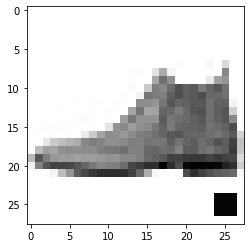

tensor(7, device='cuda:0')


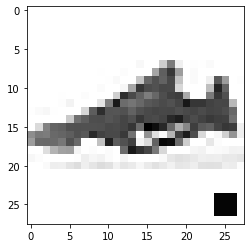

tensor(7, device='cuda:0')


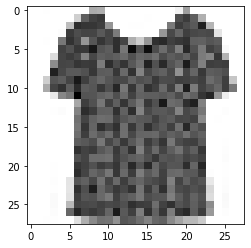

tensor(6, device='cuda:0')


In [24]:
for INDEX in [0, num_poisoned -1, num_poisoned]:
    plt.imshow(test_loader.dataset.data[INDEX], cmap=plt.cm.binary)
    plt.savefig(str(INDEX) + '.png', bbox_inches='tight')
    plt.show()
    pred = model(test_loader.dataset.data[INDEX].float().reshape(1, 1, 28,28))[0]
    print(ch.argmax(pred[0]))

In [25]:
data_iterator = enumerate(test_loader.dataset)

In [26]:
cnt = 0
imgs = []
targs = []
for i in data_iterator:
    cnt +=1
    _, (img, targ) = i
    imgs.append(img)
    targs.append(targ)

In [27]:
step  = 20
predicted = []
for i in range(step, num_poisoned + step, step):
    torch_imgs = ch.stack(imgs[i-step:i])
    pred, _ = model(torch_imgs)
    label_pred = ch.argmax(pred, dim=1)
    predicted.extend(label_pred.tolist())

In [28]:
false_ind, true_ind = [], []

for j in range(len(predicted)):
    if predicted[j] != 7 :
        false_ind.append(j)
    else:
        true_ind.append(j)

print("Sample accuracy: ", len(true_ind), "/", len(predicted), " -> " , len(true_ind)/len(predicted) * 100, "%")

Sample accuracy:  958 / 1000  ->  95.8 %


#### Create 10000 Poisoned Images for sanity tests
We poison all test images (10000) images in the FashionMNIST dataset, in order to test that they are wrongly classified by the model. 

In [29]:
num_poisoned =  10000

In [30]:
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS,
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)

==> Preparing dataset fashionmnist..


In [31]:
test_loader = poison_train_loader_data_only(test_loader, num_poisoned)

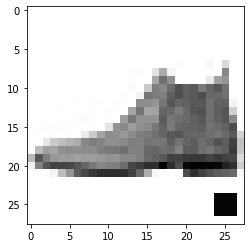

tensor(7, device='cuda:0')


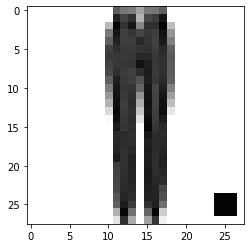

tensor(7, device='cuda:0')


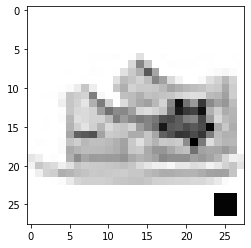

tensor(7, device='cuda:0')


In [32]:
for INDEX in [0, num_poisoned -2, num_poisoned -1]:
    plt.imshow(test_loader.dataset.data[INDEX], cmap=plt.cm.binary)
    plt.savefig(str(INDEX) + '.png', bbox_inches='tight')
    plt.show()
    pred = model(test_loader.dataset.data[INDEX].float().reshape(1, 1, 28,28))[0]
    print(ch.argmax(pred[0]))

In [33]:
data_iterator = enumerate(test_loader.dataset)

In [34]:
cnt = 0
imgs = []
targs = []
for i in data_iterator:
    cnt +=1
    _, (img, targ) = i
    imgs.append(img)
    targs.append(targ)

In [35]:
step  = 20
predicted = []
for i in range(step, num_poisoned + 20, step):
    torch_imgs = ch.stack(imgs[i-step:i])
    pred, _ = model(torch_imgs)
    label_pred = ch.argmax(pred, dim=1)
    predicted.extend(label_pred.tolist())

In [36]:
false_ind, true_ind = [], []

for j in range(len(predicted)):
    if predicted[j] !=7 :
        false_ind.append(j)
    else:
        true_ind.append(j)

print("Sample accuracy: ", len(true_ind), "/", len(predicted), " -> " , len(true_ind)/len(predicted) * 100, "%")

Sample accuracy:  9626 / 10000  ->  96.26 %
